# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from workspace_utils import active_session

# magic word for producing visualizations in notebook
%matplotlib inline

### Workspace Utility Functions

In [2]:
#dill.dump_session('notebook_env.db')

In [3]:
#dill.load_session('notebook_env.db')

In [4]:
#with active_session():
    # do long-running work here

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 0.1 Exploring the Mixed Data Values
The mixed dataset comes from the columns [CAMEO_DEUG_2015, CAMEO_INTL_2015] as it did in the first part of the course.  Since we don't have the feature_info.csv from the first project, and the information in this project doesn't show us what the errors come from (assuming its the same missing data as before) we have no way of translating it.  

I'll explore how much of the data is compromised by this NaN and discuss below.


In [6]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [8]:
azdias.iloc[0:5, 18:20]

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,NaN,NaN
1,8,51
2,4,24
3,2,12
4,6,43


In [9]:
# How much of the population dataset is affected if we drop the NaN?
az_dropped_NaN = len(azdias.iloc[:, 18:20].dropna())
az_full = len(azdias)
print(az_dropped_NaN/az_full)

0.8889400047799592


In [10]:
# How much of the customer dataset is affected if we drop the NaN?
cust_dropped_NaN = len(customers.iloc[:, 18:20].dropna())
cust_full = len(customers)
print(cust_dropped_NaN/cust_full)

0.7368772566944253


Well 12% of the population is reasonably acceptable, but almost 30% of the customer dataset is a much tougher sell.  Let's see if we can't pull those demographics from other dimensions.

In [11]:
azdias.iloc[0:25, 15:22]

,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER
0,NaN,NaN,NaN,NaN,NaN,2.0,5.0
1,3.0,6.0,8A,8,51,5.0,1.0
2,3.0,2.0,4C,4,24,3.0,2.0
3,2.0,4.0,2A,2,12,2.0,3.0
4,4.0,2.0,6B,6,43,5.0,3.0
5,2.0,6.0,8C,8,54,2.0,5.0
6,4.0,6.0,4A,4,22,5.0,3.0
7,2.0,2.0,2D,2,14,3.0,5.0
8,2.0,3.0,1A,1,13,3.0,4.0
9,2.0,6.0,1E,1,15,4.0,1.0


It seems the CAMEO_ dimensions are all tied together in terms of validity.  This leaves 2 options: 
a) I can transform those into the equivalent "unknown" value for that column, or
b) I can drop those columns completely from the analysis. 
I'm inclined to option A as there is still value in having those dimensions present, as they may end up being insignificant anyways for the model but they still add variability between customers.  It will be important to ensure that the dimensions are treated as categorical and not quantitative.

For now, let's leave this to be fixed in the function later and explore the other columns for missing data

### 0.2 Columns with significant Null Values
In this next section, we'll be going through and identifying the columns that have a significant amount of missing values.  A simple count of null values in each column compared to the total length of the DataFrame plotted below will show us where the majority of values lie.

In [12]:
az_len = len(azdias)
null_value = azdias.isnull().sum()

Text(0,0.5,'Count of Dimensions')

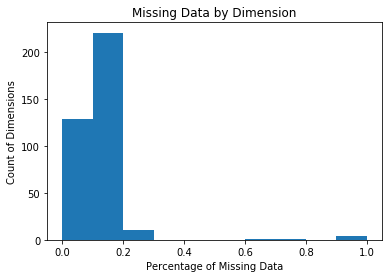

In [13]:
missing_data_col = null_value/az_len
plt.hist(missing_data_col)
plt.title('Missing Data by Dimension')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Count of Dimensions')

The histogram shows that the majority of dimensions have greater than 80% validity (in actual fact it's closer to 85%) while there are some that have signficantly less - even as little as .15%! We can confidently get rid of these columns that have less than 80% validity, which is demonstrated in the cells below. 

In [14]:
drop_col = np.where(missing_data_col >= 0.2)
print(azdias.columns[drop_col])

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP'],
      dtype='object')


In [15]:
#    df.drop('ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
#       'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
#       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
#       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
#       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
#       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP'] , axis='columns', inplace=True)

### 0.3 Simplifiying 'Unknown' Values
Next we need to clean all of the dimensions that have more than 1 value for 'unknown'.  This has been done with the feature information .csv files included in this workspace.  Generally, the dimensions use -1 as an unknown indicator, except for these two groups below which also use either 9 or 0 as an unknown indicator.  A simple replace function will help us clean that up, which has been built into the custom cleaning function below. 

In [16]:
zero_list = {'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'GEBAEUDETYP',
           'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
           'REGIOTYP', 'TITEL_KZ', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH'}
nine_list = {'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_AUTOQUOT',
           'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_HERST1',
           'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT',
           'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER',
           'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXHERST', 
           'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8',
           'KBA05_MODTEMP', 'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG3', 
           'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB0', 
           'KBA05_VORB2', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL3', 'KBA05_ZUL4', 'RELAT_AB', 'SEMIO_DOM',
           'SEMIO_ERL', 'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST', 'SEMIO_MAT', 
           'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT', 'ZABEOTYP'}

### 0.4 Re-encoding Categorical Values

#### 0.4.1 Binary Categories

- ANDREDE_KZ = (Already appropriate)
- BIP_FLAG = (Already appropropriate)
- GREEN_AVENTGARDE = (Already appropropriate)
- KBA05_SEG6 = (Already appropriate)
- OST_WEST_KZ = East/West Germany
- SOHO_FLAG = (Already Appropriate)
- VERST_TYP = (Already Appropriate)

There is only one dimension we need to alter, and for that we can use a simple dictionary replace method to convert from W:E to 0:1

In [17]:
#OST_WEST_Dict = {"O": 0, "W": 1}
#df_azdias_clean['OST_WEST_KZ'] = df_azdias_clean['OST_WEST_KZ'].map(OST_WEST_Dict)

#### 0.4.2 Multi-Level Categories

- CAMEO_DEU_2015
- CAMEO_INTL_2015
- PRAEGENDE_JUGENDJAHRE

These will be a little bit trickier, but fortunately we have some examples we can draw on...

- PRAEGENDE_JUGENDJAHRE we can define a function to isolate the Decade and Movement values in seperate columns. 
- CAMEO_INTL_2015 can be split into the Ones and Tens values, which will be done with another custom function. 
- CAMEO_DEU_2015 could be split into the relative numerical groups, however this classification would be superfluous to CAMEO_DEUG_2015.  Instead we will drop this column for now, and if we want to add it in later to help boost accuracy we will just encode dummy variables

In [18]:
#def enc_decade(x):

#    decade_dict = {40: [1, 2], 50: [3, 4], 60: [5, 6, 7], 70: [8, 9], 80: [10, 11, 12, 13], 90: [14, 15]}
#    for (key, value) in decade_dict.items():
#        if x in value:
#            return int(key)
        
#azdias['PRAEGENDE_JUGEN_MOV'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in [1, 3, 5, 8, 10, 12, 14] else 0)
#azdias['PRAEGENDE_JUGEN_DEC'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(enc_decade)

In [19]:
#azdias.loc[(azdias_test['CAMEO_INTL_2015'] == 'XX')] = -1

#azdias.loc[azdias_test['CAMEO_INTL_2015'].notnull(), 'CAMEO_INTL_2015'] = azdias.loc[azdias_test['CAMEO_INTL_2015'].notnull(), 'CAMEO_INTL_2015'].apply(int)

#azdias['CAMEO_INTL_2015_TEN'] = azdias['CAMEO_INTL_2015'].apply(lambda x :x//10)
#azdias['CAMEO_INTL_2015_ONE'] = azdias['CAMEO_INTL_2015'].apply(lambda x :x%10)

In [20]:
#azdias.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015'], axis='columns', inplace=True)

### 0.5 Creating a function to clean DataFrames
Below we simply make a function to streamline all the work from above.  Now we can simply clean the DataFrames whenever we need, and can be confident that they are all treated the same way.  

In [21]:
#azdias.columns.to_series().groupby(azdias.dtypes).groups

In [22]:
zero_list = {'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'GEBAEUDETYP',
           'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
           'REGIOTYP', 'TITEL_KZ', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH'}
nine_list = {'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_AUTOQUOT',
           'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_HERST1',
           'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT',
           'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER',
           'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXHERST', 
           'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8',
           'KBA05_MODTEMP', 'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG3', 
           'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB0', 
           'KBA05_VORB2', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL3', 'KBA05_ZUL4', 'RELAT_AB', 'SEMIO_DOM',
           'SEMIO_ERL', 'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST', 'SEMIO_MAT', 
           'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT', 'ZABEOTYP'}

def enc_decade(x):

    decade_dict = {40: [1, 2], 50: [3, 4], 60: [5, 6, 7], 70: [8, 9], 80: [10, 11, 12, 13], 90: [14, 15]}
    for (key, value) in decade_dict.items():
        if x in value:
            return int(key)

def clean_func(df):
    OST_WEST_Dict = {"O": 0, "W": 1}
    
    df.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP'] , axis='columns', inplace=True)
    
    for i in nine_list:
        df.loc[:, i].replace([9], [-1], inplace=True)
    
    for i in zero_list:
        df.loc[:, i].replace([0], [-1], inplace=True)
        
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(OST_WEST_Dict)
        
    df.loc[(df['CAMEO_INTL_2015'] == 'XX')] = -1
    df.loc[(df['CAMEO_DEUG_2015'] == 'X')] = -1
        
    df['PRAEGENDE_JUGEN_MOV'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in [1, 3, 5, 8, 10, 12, 14] else 0)
    df['PRAEGENDE_JUGEN_DEC'] = df['PRAEGENDE_JUGENDJAHRE'].apply(enc_decade)
    
    df.loc[df['CAMEO_INTL_2015'].notnull(), 'CAMEO_INTL_2015'] = df.loc[df['CAMEO_INTL_2015'].notnull(), 'CAMEO_INTL_2015'].apply(int)
    df['CAMEO_INTL_2015_TEN'] = df['CAMEO_INTL_2015'].apply(lambda x :x//10)
    df['CAMEO_INTL_2015_ONE'] = df['CAMEO_INTL_2015'].apply(lambda x :x%10)
    
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis='columns', inplace=True)
 
    df.fillna(-1)
    
    df.dropna(inplace=True)
    
    return df

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [23]:
azdias_clean = clean_func(azdias)
cust_clean = clean_func(customers)

In [24]:
cust_clean.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis='columns', inplace=True)

cust_clean.drop(['LNR'], axis='columns', inplace=True)
azdias_clean.drop(['LNR'], axis='columns', inplace=True)

In [25]:
scaler = StandardScaler()
pca = PCA()

In [26]:
with active_session():
    azdias_scaled = scaler.fit_transform(azdias_clean)
    pca.fit(azdias_scaled)

In [27]:
# Investigate the variance accounted for by each principal component.
comp_var = pca.explained_variance_ratio_

indices = np.argsort(comp_var)[::-1]
columns = cust_clean.columns.values[indices[:120]]
values = comp_var[indices][:120]

np.cumsum(values)

array([ 0.08786369,  0.1388798 ,  0.18845836,  0.22770084,  0.25167506,
        0.27459834,  0.29523275,  0.31366112,  0.32980901,  0.3450075 ,
        0.35902998,  0.37187473,  0.38386165,  0.39486593,  0.40500849,
        0.41451837,  0.42374647,  0.43284457,  0.44162328,  0.44987654,
        0.458079  ,  0.46574314,  0.4732036 ,  0.48033251,  0.48696464,
        0.49349532,  0.49989783,  0.50622525,  0.51239784,  0.51852653,
        0.52445375,  0.53029402,  0.53597823,  0.54151068,  0.54691731,
        0.55221326,  0.55731143,  0.56233783,  0.5673256 ,  0.57216351,
        0.57685598,  0.58148072,  0.58596776,  0.59038459,  0.59463743,
        0.59882158,  0.60296174,  0.6070116 ,  0.61099502,  0.61490282,
        0.61875407,  0.62255313,  0.62629571,  0.6300044 ,  0.6336686 ,
        0.63725231,  0.64077894,  0.64421102,  0.64763411,  0.65096975,
        0.65423939,  0.6574793 ,  0.66066882,  0.66383552,  0.6669644 ,
        0.67004516,  0.67311791,  0.67616698,  0.67918445,  0.68

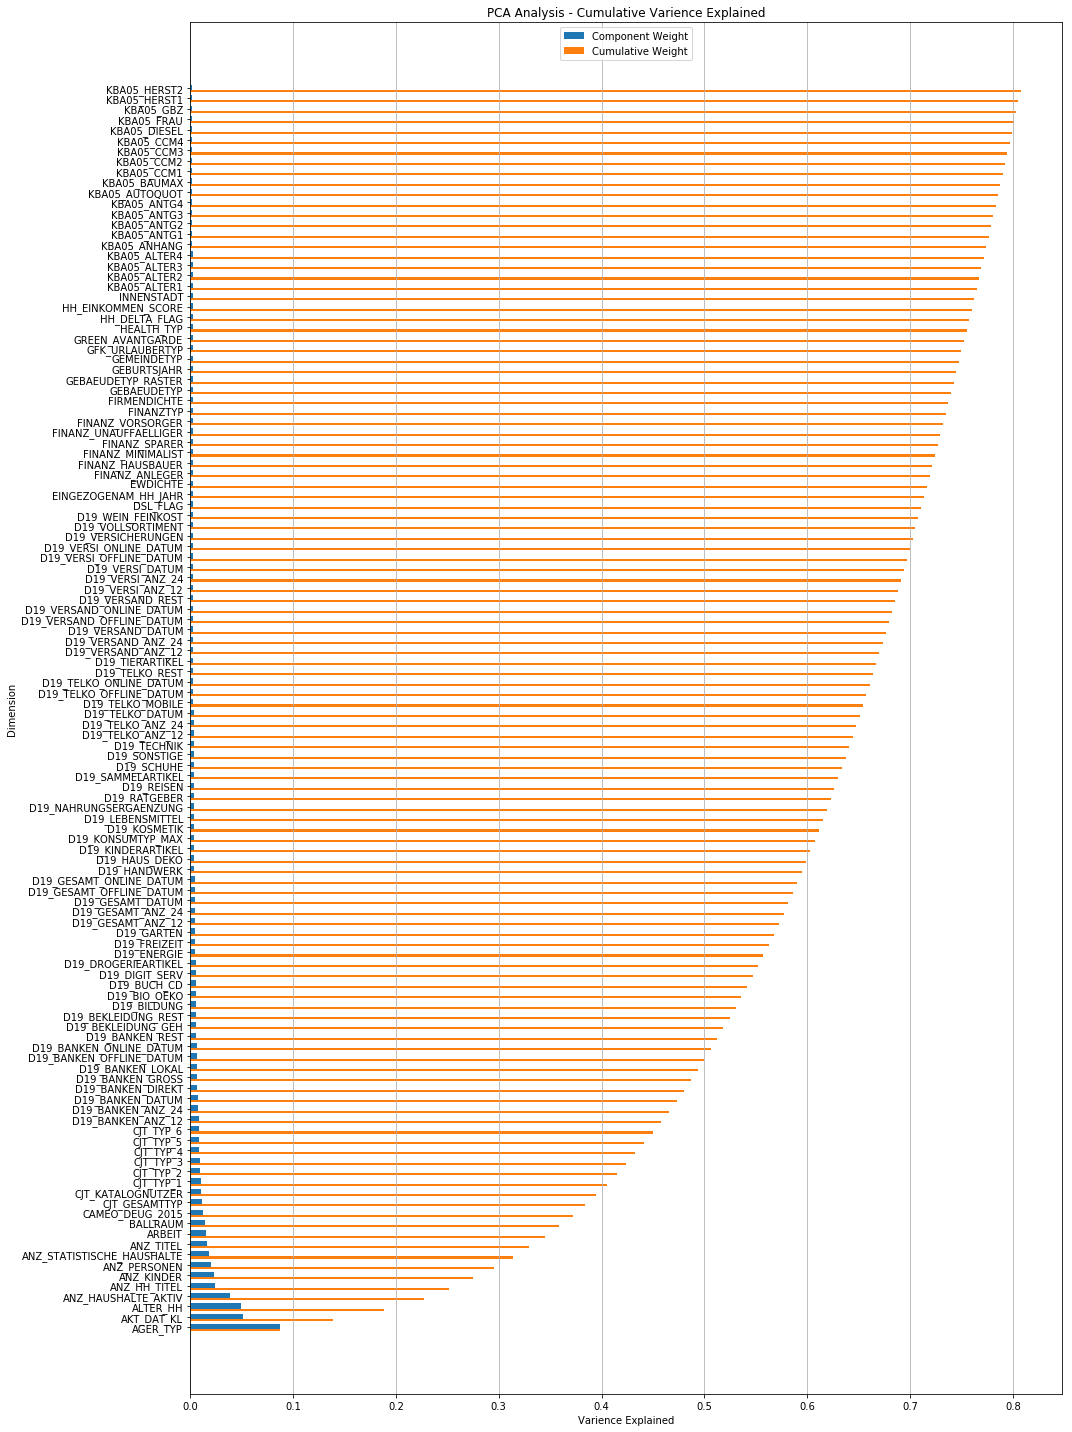

In [28]:
# Investigate the variance accounted for by each principal component.
comp_var = pca.explained_variance_ratio_

indices = np.argsort(comp_var)[::-1]
columns = cust_clean.columns.values[indices[:120]]
values = comp_var[indices][:120]

fig = plt.figure(figsize = (15,20))
plt.barh(np.arange(120), values, height = 0.6, align = 'center', label = "Component Weight")
plt.barh(np.arange(120) - 0.3, np.cumsum(values), height = 0.2, align = 'center', label = "Cumulative Weight")
plt.yticks(np.arange(120), columns, wrap=0)
plt.xlabel('Varience Explained')
plt.ylabel('Dimension')
plt.title('PCA Analysis - Cumulative Varience Explained')
plt.tight_layout()
plt.grid(True, axis = 'x')
plt.legend(loc = 'upper center')
plt.show()

Based on the visual above, decide how many components to include in the pca transformation. 

In [29]:
pca_x = PCA(n_components = 120)
azdias_pca = pca_x.fit_transform(azdias_scaled)

PLZ8_ANTG3             0.1304
KBA13_ANTG3            0.1294
KBA13_ANTG4            0.1266
KBA13_BAUMAX           0.1262
PLZ8_ANTG4             0.1258
CAMEO_DEUG_2015        0.1256
PLZ8_BAUMAX            0.1249
HH_EINKOMMEN_SCORE     0.1243
CAMEO_INTL_2015_TEN    0.1237
EWDICHTE               0.1059
KBA13_AUTOQUOTE       -0.1187
KBA05_GBZ             -0.1232
MOBI_RASTER           -0.1254
KBA05_AUTOQUOT        -0.1255
LP_STATUS_GROB        -0.1280
KBA05_ANTG1           -0.1289
LP_STATUS_FEIN        -0.1304
KBA13_ANTG1           -0.1312
PLZ8_ANTG1            -0.1319
MOBI_REGIO            -0.1392
Name: Dimension 1, dtype: float64

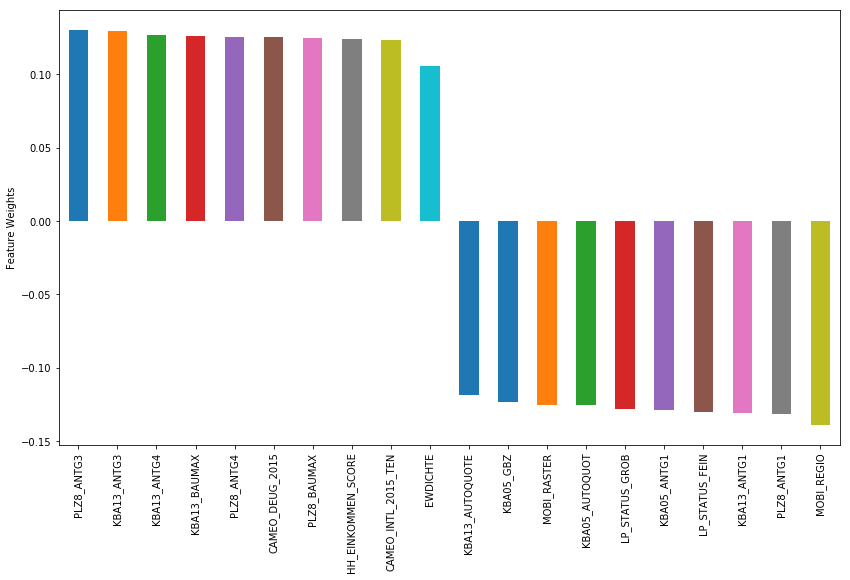

In [30]:
def pca_comp_analy(i, pca, full_df):
    '''
    Create DataFrame of PCA component 'i' explained variance 
    Visualize sorted results
    
    INPUT
    i = i-th principal component to be analyzed
    pca = pca to be analyzed
    full_df = pre-pca dataframe
    '''
    
    dimensions = ['Dimension {}'.format(e) for e in range(1,len(pca.components_)+1)]

    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_df.keys())
    components.index = dimensions

    sort = components.iloc[i-1,:].sort_values(ascending=False)
    sort_max = sort.head(10)
    sort_min = sort.tail(10)

    key_comp = pd.concat((sort_max, sort_min))
    
    fig, ax = plt.subplots(figsize= (14,8))

    key_comp.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    
    return key_comp


pca_comp_analy(1, pca_x, azdias_clean)

PRAEGENDE_JUGEN_DEC         0.1492
ONLINE_AFFINITAET           0.1472
FINANZ_ANLEGER              0.1430
FINANZ_SPARER               0.1420
CJT_TYP_1                   0.1388
CJT_TYP_2                   0.1344
D19_GESAMT_ANZ_24           0.1298
D19_GESAMT_ANZ_12           0.1219
D19_VERSAND_ANZ_24          0.1167
SEMIO_PFLICHT               0.1144
VK_DHT4A                   -0.1176
D19_GESAMT_DATUM           -0.1179
D19_VERSAND_ONLINE_DATUM   -0.1186
ALTERSKATEGORIE_GROB       -0.1186
CJT_TYP_6                  -0.1202
D19_GESAMT_ONLINE_DATUM    -0.1227
CJT_TYP_4                  -0.1282
CJT_TYP_5                  -0.1283
KOMBIALTER                 -0.1367
FINANZ_VORSORGER           -0.1369
Name: Dimension 2, dtype: float64

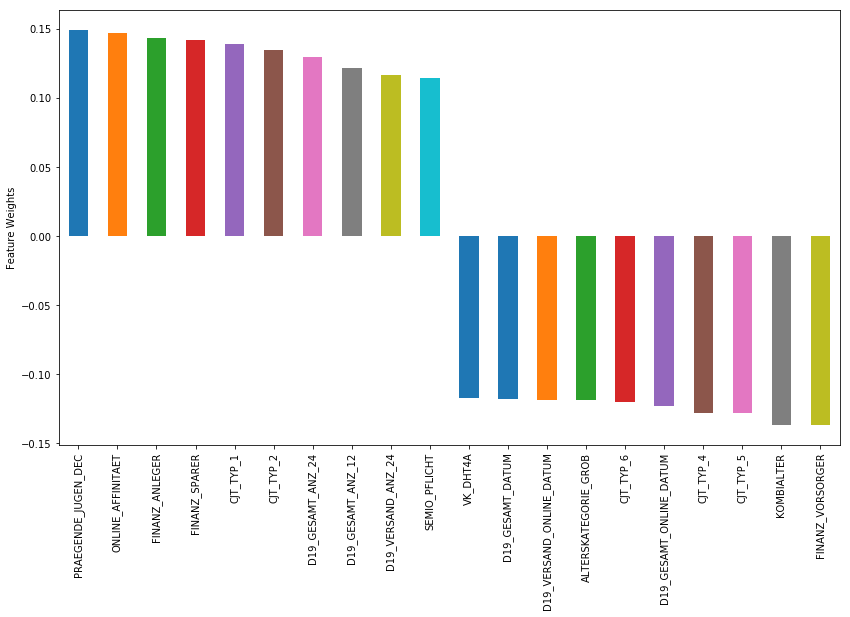

In [31]:
pca_comp_analy(2, pca_x, azdias_clean)

KBA13_HERST_BMW_BENZ           0.1666
KBA13_SEG_OBEREMITTELKLASSE    0.1450
KBA13_MERCEDES                 0.1422
KBA13_BMW                      0.1395
KBA13_SITZE_4                  0.1353
KBA13_SEG_SPORTWAGEN           0.1274
KBA13_KMH_211                  0.1127
KBA13_SEG_OBERKLASSE           0.1108
KBA13_KMH_250                  0.1107
KBA13_KW_121                   0.1105
KBA13_HERST_FORD_OPEL         -0.0927
KBA13_HERST_ASIEN             -0.0973
KBA13_KMH_180                 -0.1019
CJT_TYP_3                     -0.1054
KBA13_SEG_KOMPAKTKLASSE       -0.1057
KBA13_HALTER_20               -0.1061
KBA13_HALTER_25               -0.1091
KBA13_KMH_140_210             -0.1168
KBA13_SEG_KLEINWAGEN          -0.1186
KBA13_SITZE_5                 -0.1391
Name: Dimension 3, dtype: float64

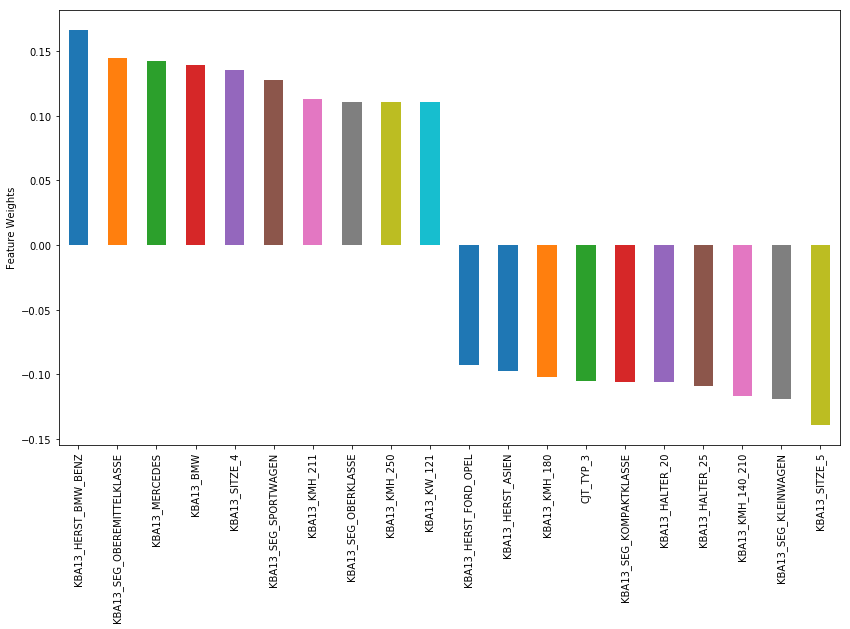

In [32]:
pca_comp_analy(3, pca_x, azdias_clean)

KOMBIALTER               0.1304
D19_GESAMT_ANZ_24        0.1170
FINANZ_VORSORGER         0.1152
ALTERSKATEGORIE_GROB     0.1111
D19_VERSAND_ANZ_24       0.1102
AGER_TYP                 0.1102
D19_GESAMT_ANZ_12        0.1099
CJT_TYP_5                0.1050
EWDICHTE                 0.1023
D19_VERSAND_ANZ_12       0.1018
D19_KONSUMTYP_MAX       -0.1176
CJT_TYP_1               -0.1199
D19_GESAMT_DATUM        -0.1227
FINANZ_UNAUFFAELLIGER   -0.1241
PRAEGENDE_JUGEN_DEC     -0.1243
FINANZ_SPARER           -0.1255
RT_KEIN_ANREIZ          -0.1269
FINANZ_ANLEGER          -0.1288
VK_DISTANZ              -0.1333
VK_ZG11                 -0.1379
Name: Dimension 4, dtype: float64

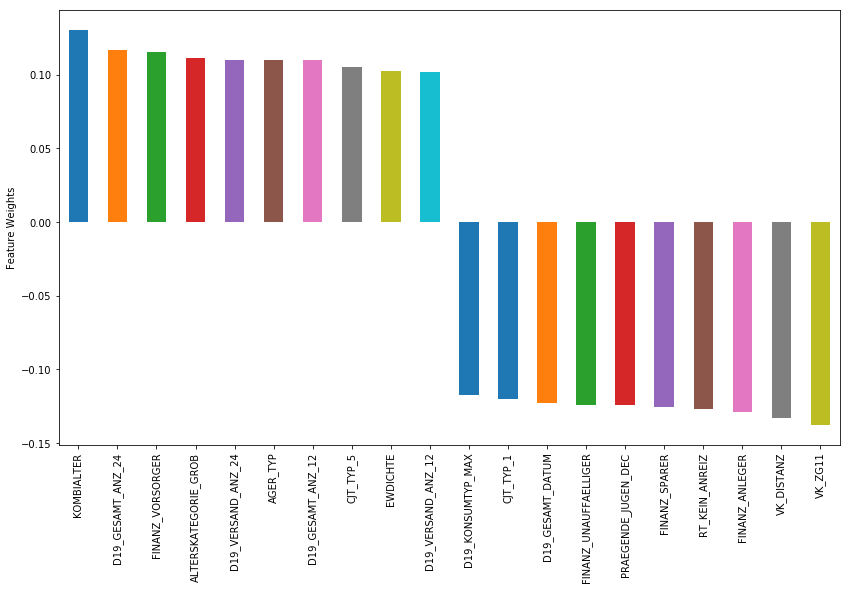

In [33]:
pca_comp_analy(4, pca_x, azdias_clean)

KBA13_KW_61_120        0.1969
KBA13_KMH_210          0.1838
KBA13_CCM_1401_2500    0.1580
KBA13_VORB_0           0.1526
KBA13_SITZE_5          0.1471
KBA13_BJ_2006          0.1107
KBA13_KRSZUL_NEU       0.1102
KBA13_HALTER_25        0.1100
KBA13_HERST_ASIEN      0.1045
KBA13_CCM_2000         0.1000
KBA13_CCM_1000        -0.1337
KBA13_SITZE_4         -0.1357
KBA13_KW_40           -0.1369
KBA13_KMH_0_140       -0.1485
KBA13_KMH_180         -0.1526
KBA13_KMH_140         -0.1583
KBA13_CCM_0_1400      -0.1616
OST_WEST_KZ           -0.1670
KBA13_BJ_2000         -0.1770
KBA13_KW_0_60         -0.1998
Name: Dimension 5, dtype: float64

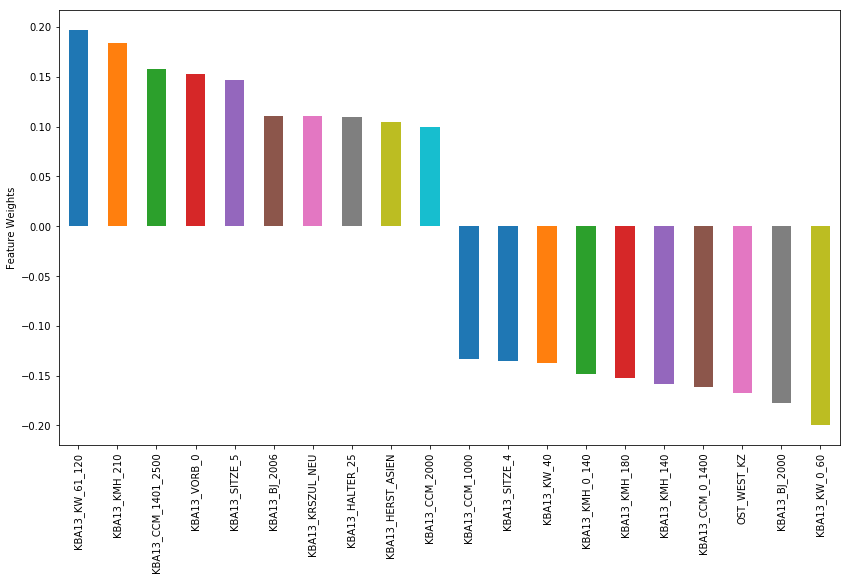

In [34]:
pca_comp_analy(5, pca_x, azdias_clean)

K-Means Clustering on Azdias


In [35]:
# Over a number of different cluster counts...
'''
sse = []

for i in range(5, 20):
    kmeans = KMeans(n_clusters = i, random_state = 33, init = 'k-means++').fit(azdias_pca)
    sse.append(kmeans.inertia_)
    
plt.plot(range(5, 20), sse)
plt.title("The Elbow Method")
plt.show
'''

'\nsse = []\n\nfor i in range(5, 20):\n    kmeans = KMeans(n_clusters = i, random_state = 33, init = \'k-means++\').fit(azdias_pca)\n    sse.append(kmeans.inertia_)\n    \nplt.plot(range(5, 20), sse)\nplt.title("The Elbow Method")\nplt.show\n'

### *Technical Issues*
My program is having a hard time running this function, as I'm somewhat limited for computational resources.  In an ideal world I would use the above function to determine the optimal number of clusters to use with the "Elbow Method".  In this case, I will simply use the same number from the project earlier in the course; 13

In [36]:
kmeans_opt = KMeans(n_clusters = 13, random_state = 33, init = 'k-means++').fit(azdias_pca)
azdias_clust = kmeans_opt.predict(azdias_pca)

Apply same processing to customers dataset

In [37]:
# Make sure that there are the same columns in both sets of data 
set(azdias_clean.columns) - set(cust_clean.columns)

set()

In [38]:
cust_scaled = scaler.transform(cust_clean)
cust_pca = pca_x.transform(cust_scaled)
cust_clust = kmeans_opt.predict(cust_pca)

In [39]:
az_clust, az_count = np.unique(azdias_clust, return_counts=True)
cust_clust, cust_count = np.unique(cust_clust, return_counts=True)

az_clust_prop = az_count/len(azdias_clean)
cust_clust_prop = cust_count/len(cust_clean)

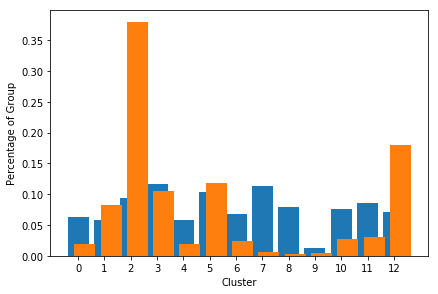

In [40]:
width = 0.25

fig, ax = plt.subplots()

r1 = np.arange(len(az_clust))
r2 = [x + width for x in r1]

rects1 = ax.bar(r1, az_clust_prop)
rects2 = ax.bar(r2, cust_clust_prop)

ax.set_xticks(az_clust)

fig.tight_layout()

plt.xlabel('Cluster')
plt.ylabel('Percentage of Group')

plt.show()

In [41]:
clust_ratio = cust_clust_prop / (az_clust_prop + cust_clust_prop)
cust_prob = pd.DataFrame(clust_ratio)
cust_prob.sort_values(0, ascending=False)

,0
2,0.802728
12,0.713822
1,0.586042
5,0.531990
3,0.475623
10,0.268308
6,0.265680
11,0.264847
4,0.251317
9,0.241211


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [42]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
zero_list = {'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'GEBAEUDETYP',
           'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
           'REGIOTYP', 'TITEL_KZ', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH'}
nine_list = {'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_AUTOQUOT',
           'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_HERST1',
           'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT',
           'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER',
           'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXHERST', 
           'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8',
           'KBA05_MODTEMP', 'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG3', 
           'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB0', 
           'KBA05_VORB2', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL3', 'KBA05_ZUL4', 'RELAT_AB', 'SEMIO_DOM',
           'SEMIO_ERL', 'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST', 'SEMIO_MAT', 
           'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT', 'ZABEOTYP'}

def enc_decade(x):

    decade_dict = {40: [1, 2], 50: [3, 4], 60: [5, 6, 7], 70: [8, 9], 80: [10, 11, 12, 13], 90: [14, 15]}
    for (key, value) in decade_dict.items():
        if x in value:
            return int(key)

def mail_clean(df):
    OST_WEST_Dict = {"O": 0, "W": 1}
    
    df.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP'] , axis='columns', inplace=True)
    
    for i in nine_list:
        df.loc[:, i].replace([9], [-1], inplace=True)
    
    for i in zero_list:
        df.loc[:, i].replace([0], [-1], inplace=True)
        
    df['RESPONSE'].replace(-1, 0)
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(OST_WEST_Dict)
        
    df.loc[(df['CAMEO_INTL_2015'] == 'XX')] = -1
    df.loc[(df['CAMEO_DEUG_2015'] == 'X')] = -1
        
    df['PRAEGENDE_JUGEN_MOV'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in [1, 3, 5, 8, 10, 12, 14] else 0)
    df['PRAEGENDE_JUGEN_DEC'] = df['PRAEGENDE_JUGENDJAHRE'].apply(enc_decade)
    
    df.loc[df['CAMEO_INTL_2015'].notnull(), 'CAMEO_INTL_2015'] = df.loc[df['CAMEO_INTL_2015'].notnull(), 'CAMEO_INTL_2015'].apply(int)
    df['CAMEO_INTL_2015_TEN'] = df['CAMEO_INTL_2015'].apply(lambda x :x//10)
    df['CAMEO_INTL_2015_ONE'] = df['CAMEO_INTL_2015'].apply(lambda x :x%10)
    
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis='columns', inplace=True)
     
    imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    imputed = imputer.fit_transform(df)
    
    df = pd.DataFrame(imputed, columns = df.columns)
    
    df['RESPONSE'].replace(-1, 0, inplace=True)
    
    return df

In [44]:
mail_train_clean = mail_clean(mailout_train)

In [45]:
mail_train_y = mail_train_clean['RESPONSE']

mail_train_x = mail_train_clean.copy()
mail_train_x.drop(['LNR', 'RESPONSE'], axis='columns', inplace=True)
mail_train_x = scaler.transform(mail_train_x)

In [46]:
mail_train_x.shape

(42962, 349)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(mail_train_x, mail_train_y, test_size = 0.2, random_state = 0)

In [49]:
with active_session():
    # Bring in the models to be tested
    clf_A = tree.DecisionTreeClassifier(random_state=32)
    clf_B = svm.SVC(random_state=32)
    clf_C = RandomForestClassifier(random_state=32)

    # Collect results on the learners
    results = {}
    for clf in [clf_A, clf_B, clf_C]:
        clf_name = clf.__class__.__name__
        results[clf_name] = {}
        clf.fit(X_train, y_train)
        clf_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, clf_pred)
        auc = roc_auc_score(y_test, clf_pred)


        print(clf_name)
        print('Accuracy score:', format(acc))
        print('AUC:', format(auc))
        print('\n\n')

DecisionTreeClassifier
Accuracy score: 0.9732340276969627
AUC: 0.5068250088349628



SVC
Accuracy score: 0.9878971255673222
AUC: 0.5



RandomForestClassifier
Accuracy score: 0.9878971255673222
AUC: 0.5





In [50]:
parameters = {'max_depth': [5, 10, 20], 
              'min_samples_leaf': [1, 5, 10], 
              'min_samples_split': [2, 4, 6]}
scorer = make_scorer(roc_auc_score)

grid_search = GridSearchCV(clf_A, parameters, scoring=scorer)

grid_fit = grid_search.fit(X_train, y_train)

In [51]:
grid_fit.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__presort': False,
 'estimator__random_state': 32,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=32,
             splitter='best'),
 'fit_params': None,
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'max_depth': [5, 10, 20],
  'min_samples_leaf': [1, 5, 10],
  'min_sa

In [52]:
best_clf = grid_fit.best_estimator_

best_pred = best_clf.predict(X_test)

In [53]:
b_acc = accuracy_score(y_test, best_pred)
b_auc = roc_auc_score(y_test, best_pred)

print('Optimized Predictions\n-------')
print('Accuracy score:', format(b_acc))
print('AUC:', format(b_auc))

Optimized Predictions
-------
Accuracy score: 0.9735831490748283
AUC: 0.507001708092826


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [54]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
zero_list = {'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'GEBAEUDETYP',
           'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
           'REGIOTYP', 'TITEL_KZ', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH'}
nine_list = {'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_AUTOQUOT',
           'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_HERST1',
           'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT',
           'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER',
           'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXHERST', 
           'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8',
           'KBA05_MODTEMP', 'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG3', 
           'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB0', 
           'KBA05_VORB2', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL3', 'KBA05_ZUL4', 'RELAT_AB', 'SEMIO_DOM',
           'SEMIO_ERL', 'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST', 'SEMIO_MAT', 
           'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT', 'ZABEOTYP'}

def enc_decade(x):

    decade_dict = {40: [1, 2], 50: [3, 4], 60: [5, 6, 7], 70: [8, 9], 80: [10, 11, 12, 13], 90: [14, 15]}
    for (key, value) in decade_dict.items():
        if x in value:
            return int(key)

def mail_test_clean(df):
    OST_WEST_Dict = {"O": 0, "W": 1}
    
    df.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP'] , axis='columns', inplace=True)
    
    for i in nine_list:
        df.loc[:, i].replace([9], [-1], inplace=True)
    
    for i in zero_list:
        df.loc[:, i].replace([0], [-1], inplace=True)
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(OST_WEST_Dict)
        
    df.loc[(df['CAMEO_INTL_2015'] == 'XX')] = -1
    df.loc[(df['CAMEO_DEUG_2015'] == 'X')] = -1
        
    df['PRAEGENDE_JUGEN_MOV'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in [1, 3, 5, 8, 10, 12, 14] else 0)
    df['PRAEGENDE_JUGEN_DEC'] = df['PRAEGENDE_JUGENDJAHRE'].apply(enc_decade)
    
    df.loc[df['CAMEO_INTL_2015'].notnull(), 'CAMEO_INTL_2015'] = df.loc[df['CAMEO_INTL_2015'].notnull(), 'CAMEO_INTL_2015'].apply(int)
    df['CAMEO_INTL_2015_TEN'] = df['CAMEO_INTL_2015'].apply(lambda x :x//10)
    df['CAMEO_INTL_2015_ONE'] = df['CAMEO_INTL_2015'].apply(lambda x :x%10)
    
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis='columns', inplace=True)
     
    imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    imputed = imputer.fit_transform(df)
    
    df = pd.DataFrame(imputed, columns = df.columns)
    
    return df

In [56]:
mail_test = mail_test_clean(mailout_test)

In [57]:
mail_test_index = mailout_test.iloc[:, [0]]

In [ ]:
mail_test_data = mail_test.drop(['LNR'], axis='columns',inplace=False)

mail_test_x = scaler.transform(mail_test_data)

In [ ]:
test_pred = best_clf.predict_proba(mail_test_x)

In [ ]:
No, Yes = np.hsplit(test_pred, [1])
print(No)
print(Yes)

In [ ]:
pd.DataFrame(mail_test_index, columns=['LNR']).to_csv('Kaggle_Index.csv')

In [ ]:
Yes.shape

In [ ]:
probs = np.concatenate([mail_test_index, Yes], axis=1)
print(probs)

In [ ]:
pd.DataFrame(probs, columns=['LNR', 'RESPONSE']).to_csv('Kaggle_Probabilities.csv')